In [3]:
import numpy as np 
import scipy.linalg
from scipy import sparse
import matplotlib.pyplot as plt
from sklearn import datasets
import heapq
%matplotlib inline

ImportError: cannot import name 'show_config' from 'numpy' (unknown location)

In [2]:
#operator的类
class operator:
    def __init__(self, target, op):
        self.target = target
        self.op = op
        self.flag = 0

In [3]:
#control operator
class ctroperator:
    def __init__(self, control, target, op):
        self.target = target 
        self.control = control
        self.op = op
        self.flag = 0  

In [4]:
class Qcircuit:
    qubits = 0
    def __init__(self, N):
        self.gatelist=[]
        Qcircuit.qubits = N
    def add_ctr_op(self, control, target, op):
        tmp = ctroperator(control, target, op)
        self.gatelist.append(tmp)
    def add_op(self, target, op):
        tmp = operator(target, op)
        self.gatelist.append(tmp)

    def computing(self,state):
         for i in self.gatelist:
             if isinstance(i,operator):
                 if isinstance(i.target,list):
                    state=self.computing_IU(i.op,state,i.target[0])
                 else:
                    state=self.computing_IU(i.op,state,i.target)
             elif isinstance(i,ctroperator):
                 state=self.computing_CU(i,state)
         return state
    def AddOp(self,op):
        self.gatelist.append(op)
    
    def computing_IU(self,gate,state,pos):
        A=self.qubits-pos
        for i in range(2**pos):
            state[i*2**(A):(i+1)*2**(A)]=self.computing_UI(gate,state[i*2**(A):(i+1)*2**(A)])
        return state

    def computing_UI(self,gate,state):
        N=np.shape(gate)[0]
        rho=np.reshape(state,(N,-1))
        rho=np.dot(gate,rho)
        return np.reshape(rho,(-1))

    def computing_CU(self,gate,state):
        state1=state.copy()
        state1=self.computing_IU(Up,state1,gate.control)
        state=self.computing_IU(Down,state,gate.control)
        state=self.computing_IU(gate.op,state,gate.target[0])
        return state+state1

In [5]:
#is hermitian?
def ishermit(matrix):
    if (matrix == matrix.conj().T).all():
        return True
    else:
        return False

In [6]:
def ctr_U(H,N):
    I = np.identity(H.shape[0])
    for i in range(2**N):
        I = np.dot(I,H)
    return I

In [7]:
def inv_R_k(k):
    return np.array([[1,0],[0,np.exp(-2*np.pi*1j/np.power(2,k))]])

In [8]:
X=np.array([[0,1],[1,0]])
H=np.array([[1,1],[1,-1]])/np.sqrt(2)
Up=np.array([[1,0],[0,0]])
Down=np.array([[0,0],[0,1]])

In [9]:
def moons(N,noise,k):
    moon = datasets.make_moons(N,noise=noise)
    point_sites = moon[0]
    index_list = []
    for i in point_sites:
        tmp = -1*np.sqrt(np.sum(np.square(i-point_sites),axis = 1))
        index_list.append(heapq.nlargest(k,range(N),tmp.take))
    W = np.zeros((N,N))
    for i in index_list:
        for j in range(1,k):
            if i[0] in index_list[i[j]]:
                W[i[0]][i[j]] = 1
    return W , moon

In [10]:
def gendata(N,data,k):
    point_sites = data[0]
    index_list = []
    for i in point_sites:
        tmp = -1*np.sqrt(np.sum(np.square(i-point_sites),axis = 1))
        index_list.append(heapq.nlargest(k,range(N),tmp.take))
    W = np.zeros((N,N))
    for i in index_list:
        for j in range(1,k):
            if i[0] in index_list[i[j]]:
                #W[i[0]][i[j]] = -np.linalg.norm(point_sites[i[0]]-point_sites[i[j]])
                W[i[0]][i[j]] = 1
    return W

In [11]:
def Laplace(W):
    diagment = np.sum(W,axis=1)
    D=np.diag(diagment)
    return (D-W)/(2*np.max(diagment))

In [12]:
phase = 9
system = 8
N=phase + 2*system
qpe=Qcircuit(N)

In [13]:
W, moon = moons(256,0.1,12)
blobs = datasets.make_blobs(2**system,n_features=2,centers=2,random_state=2)
W = gendata(2**system,blobs,k=4)

x, y = datasets.make_blobs(n_samples=2**system, random_state=3,centers=3)
transformation =np.array([[0.8, -0.9], [-0, 1]])
X_aniso = np.dot(x, transformation)
aniso = (X_aniso, y)
W=gendata(2**system,aniso,k=14)

In [ ]:
plt.scatter(aniso[0][:,0:1],aniso[0][:,1:2],color="#323278",zorder=2,alpha = 1,)
W, moon = moons(2**system,0.05,12)
plt.scatter(moon[0][:,0:1],moon[0][:,1:2],color="#3A3A7A",zorder=2)#808080
for i in range(2**system):
    z1=np.zeros((2,1))
    z2=np.zeros((2,1))
    for j in range(2**system):
        if W[i,j]!=0:
            z1[0],z2[0]=moon[0][i]
            z1[1],z2[1]=moon[0][j]
            plt.plot(z1,z2,color="#808CAA",alpha = 0.5,linewidth=1,zorder=1) 
plt.show()
plt.savefig("High 22.png",dpi=600)

: 

In [59]:
L=Laplace(W)
v,w=np.linalg.eigh(L)

In [31]:
state3=state2[:2**(2*system)]

In [32]:
np.vdot(state3,np.kron(w[:,0],w[:,0]))**2

(0.2990109684909963+2.7338845802977347e-14j)

In [33]:
np.abs(np.vdot(state3,np.kron(w[:,1],w[:,1])))**2

0.2990109684909936

In [34]:
for i in range(8):
    print(np.abs(np.vdot(state3,np.kron(w[:,i],w[:,i])))**2)

0.2990109684909963
0.2990109684909936
0.29901096849095055
0.06929576505684372
0.008531193683835942
0.00485144482186002
0.0013663432305265684
0.0008919100350035635


In [35]:
rho=np.reshape(state2,(2**phase,-1))
H3=np.zeros((2**system,2**phase))
for i in range(2**system):
    # state1=rho[i,:]
    for j in range(2**phase):
        H3[i,j]=p(v[i],j)/2**(11)

In [36]:
def neighbourhood(x):
    x_tmp=x.copy()
    q=np.random.choice(np.shape(x)[0])
    if (x[q:q+1,:]==[1,0]).all():
        x_tmp[q:q+1,:]=[0,1]

    elif(x[q:q+1,:]==[0,1]).all():
        x_tmp[q:q+1,:]=[1,0]
    return x_tmp

# #标准化
def normalized(x):
    row,column=np.shape(x)[0],np.shape(x)[1]
    for i in range(column):
        a=np.sqrt(np.sum(x,axis=0))
        a[a==0] = 1
    return x/a
# def neighbourhood(x):
#     x_tmp1=x.copy()
#     x_tmp2=x.copy()
#     q=np.random.choice(np.shape(x)[0])
#     if (x[q:q+1,:]==[1,0,0]).all():
#         x_tmp1[q:q+1,:]=[0,1,0]
#         x_tmp2[q:q+1,:]=[0,0,1]

#     elif(x[q:q+1,:]==[0,1,0]).all():
#         x_tmp1[q:q+1,:]=[1,0,0]
#         x_tmp2[q:q+1,:]=[0,0,1]       

#     elif(x[q:q+1,:]==[0,0,1]).all():
#         x_tmp1[q:q+1,:]=[0,1,0]
#         x_tmp2[q:q+1,:]=[1,0,0]
#     return x_tmp1,x_tmp2
def ini_clustering(k,total):
    I=np.eye(k)
    x=np.eye(k)
    for i in range(total//k-1):
        x=np.vstack((x,I))
    x=np.vstack((x,I[:total%k,:]))
    return x

In [37]:
def HYH(U,state):
    rho=np.reshape(state,(2**system,2**system))
    rho=np.dot(U,rho)
    return np.reshape(rho,(-1))
def ptrace(state,dim1,dim2):
    #x=np.zeros((dim2,dim2),np.complex128)
    rho=np.reshape(state,(dim1,-1))
    return np.dot(rho.conj().T,rho)
def ptrace1(rho,dim1,dim2):
    x=np.zeros((dim1,dim1),np.complex128)
    for i in range(dim2):
        x+=rho[i*dim2:(i+1)*dim2,i*dim2:(i+1)*dim2]
    return x

In [38]:
rho1=ptrace(state2,2**phase,2**(2*system))

In [39]:
rho=ptrace1(rho1,2**system,2**system)

In [40]:
m3=np.outer(w[:,0],w[:,0])+np.outer(w[:,1],w[:,1])
np.trace(np.dot(m3,rho))

(0.5980219369819897+9.860761315262648e-32j)

In [41]:
np.linalg.norm(rho-m3)

1.0378296912955838

In [42]:
x = ini_clustering(2,2**system)
tmp=0
for j in range(2**(phase+2)):
    x_tmp1=neighbourhood(x)
    x_tmp_1=x_tmp1.copy()
    x_tmp1=normalized(x_tmp1)
    #state3=state2.copy()
    m=x_tmp1.dot(x_tmp1.T)
    # for i in range(2**phase):
    #     state3[i*2**(2*system):(i+1)*2**(2*system)]=HYH(m,state3[i*2**(2*system):(i+1)*2**(2*system)])
    # b1=np.vdot(state2,state3)
    b1=np.trace(np.dot(m,rho))
    if abs(b1) > tmp:
        tmp=b1
        x=x_tmp_1
print("最大值:",tmp,"\n")
print("分类结果:\n",x)
# x = ini_clustering(3,2**system)
# tmp=0

# for j in range(2**(phase+2)):
#     x_tmp1,x_tmp2=neighbourhood(x)
#     x_tmp_1=x_tmp1.copy()
#     x_tmp_2=x_tmp2.copy()
#     x_tmp1=normalized(x_tmp1)
#     x_tmp2=normalized(x_tmp2)
#     m1=x_tmp1.dot(x_tmp1.T)
#     m2=x_tmp2.dot(x_tmp2.T)
#     b1=np.trace(np.dot(m1,rho))
#     b2=np.trace(np.dot(m2,rho))
#     if abs(b1) >tmp :
#         if abs(b1)>abs(b2):
#             tmp=b1
#             x=x_tmp_1
#         else:
#             tmp=b2
#             x=x_tmp_2
#     elif  abs(b2)>tmp:
#         if abs(b2)>abs(b1):
#             tmp=b2
#             x=x_tmp_2
#         else:
#             tmp=b1
#             x=x_tmp_1
# print("最大值:",tmp,"\n")
# print("分类结果:\n",x)

最大值: (0.5980219369819896+4.930380657631324e-32j) 

分类结果:
 [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1

In [43]:
point1=[]
point2=[]
for i in range(2**system):
    if x[i][0] == 1:
        point1.append((moon[0][i:i+1,:]).tolist()[0])
    elif x[i][0] == 0:
        point2.append((moon[0][i:i+1,:]).tolist()[0])
point1=np.array(point1)
point2=np.array(point2)
# point1=[]
# point2=[]
# point3=[]
# for i in range(2**system):
#     if x[i][0] == 1:
#         point1.append((aniso[0][i:i+1,:]).tolist()[0])
#     elif x[i][1] == 1:
#         point2.append((aniso[0][i:i+1,:]).tolist()[0])
#     elif x[i][2] == 1:
#          point3.append((aniso[0][i:i+1,:]).tolist()[0])
# point1=np.array(point1)
# point2=np.array(point2)
# point3=np.array(point3)

In [44]:
# "#F781BF" 粉色"#377EB8"蓝色"#FF7F00"橘色

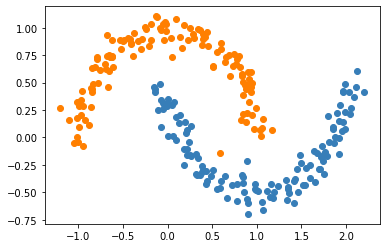

In [45]:
plt.scatter(point1[:,0:1],point1[:,1:2],color="#377EB8",alpha = 1,zorder=2)
plt.scatter(point2[:,0:1],point2[:,1:2],color="#FF7F00",alpha = 1,zorder=2)
# plt.scatter(point3[:,0:1],point3[:,1:2],color="#F781BF",alpha = 1,zorder=2)
plt.show()
#plt.savefig("High 32.png",dpi=600)

In [50]:
v

array([-8.93907518e-17, -3.84983877e-17,  6.79410017e-17,  1.20513071e-03,
        1.66187787e-03,  4.72547711e-03,  6.33140078e-03,  1.04946549e-02,
        1.52785629e-02,  1.74792723e-02,  2.49824957e-02,  2.63064281e-02,
        3.48968617e-02,  4.29153663e-02,  4.66231474e-02,  5.22620715e-02,
        7.01797388e-02,  8.01528923e-02,  8.18370016e-02,  8.20552097e-02,
        8.74288190e-02,  9.37009311e-02,  1.00669993e-01,  1.15695863e-01,
        1.21560704e-01,  1.27447817e-01,  1.34529317e-01,  1.50270621e-01,
        1.59980280e-01,  1.61198873e-01,  1.67238445e-01,  1.76490101e-01,
        1.78370501e-01,  1.81526195e-01,  1.94147544e-01,  2.00543078e-01,
        2.09232225e-01,  2.14410028e-01,  2.19772605e-01,  2.20348840e-01,
        2.20935346e-01,  2.26796471e-01,  2.28641566e-01,  2.47669151e-01,
        2.48708684e-01,  2.58471485e-01,  2.72727273e-01,  2.73084037e-01,
        2.76992677e-01,  2.78607998e-01,  2.83354894e-01,  2.85186794e-01,
        2.89355908e-01,  

In [51]:
#绿#4DAF4A 蓝#377EB8 橙#FF7F00 粉#F781BF

In [52]:
state3=state2.copy()
m3=np.outer(w[:,0],w[:,0])+np.outer(w[:,1],w[:,1])+np.outer(w[:,2],w[:,2])
# for i in range(2**phase):
#     state3[i*2**(2*system):(i+1)*2**(2*system)]=HYH(m1,state3[i*2**(2*system):(i+1)*2**(2*system)])

np.vdot(state2,state3)

(0.9999999999996804+0j)

In [53]:
# n_samples =128
# random_state = 3
# X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state,centers=3)
# transformation = [[0.6, -0.6], [-0.4, 0.9]]
# X_aniso = np.dot(X, transformation)
# aniso = (X_aniso, y)
# plt.scatter(aniso[0][:,0:1],aniso[0][:,1:2],color="#F781BF",alpha = 1,zorder=2)
# W=gendata(128,aniso,k=8)
# for i in range(128):
#     z1=np.zeros((2,1))
#     z2=np.zeros((2,1))
#     for j in range(128):
#         if W[i,j]!=0:
#             z1[0],z2[0]=aniso[0][i]
#             z1[1],z2[1]=aniso[0][j]
#             plt.plot(z1,z2,color="#808080",alpha = 0.5,zorder=1) 
# plt.show()

In [54]:
# varied = datasets.make_blobs(n_samples=64,
#                              cluster_std=[1,1,1],
#                              random_state=3)
# plt.scatter(varied[0][:,0:1],varied[0][:,1:2],color="#F781BF",alpha = 1)